In [12]:
import os
import json
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
# Rutas
img_dir = r'C:\CatFLW dataset\images'
labels_dir = r'C:\CatFLW dataset\labels'

# Definir los índices de las regiones según los puntos proporcionados
ojo_der = [3, 4, 5, 6, 7, 36, 37, 38]
ojo_izq = [1, 8, 9, 10, 11, 39, 40, 41]
oreja_der = [22, 23, 24, 25, 26]
oreja_izq = [27, 28, 29, 30, 31]
nariz = [0, 2, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 33, 34, 35, 42, 43, 44, 45, 46, 47]

# Función para calcular el punto promedio de una región
def calcular_centro_region(landmarks, indices):
    puntos = [landmarks[i] for i in indices]
    centro = np.mean(puntos, axis=0)
    return centro

# Dataset personalizado con aumentación y recorte de bounding box
class RegionCenterDataset(Dataset):
    def __init__(self, img_dir, labels_dir, transform=None):
        self.img_dir = img_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        label_path = os.path.join(self.labels_dir, img_name.replace('.png', '.json'))
        
        # Cargar imagen
        image = np.array(Image.open(img_path).convert('RGB'))
        
        # Cargar etiquetas
        with open(label_path, 'r') as f:
            labels = json.load(f)
            landmarks = labels['labels']
            bounding_box = labels['bounding_boxes']
        
        # Recortar la imagen usando el bounding box
        x_min, y_min, x_max, y_max = map(int, bounding_box)
        image_cropped = image[y_min:y_max, x_min:x_max]
        
        # Calcular los centros de las regiones
        centros = [
            calcular_centro_region(landmarks, ojo_der),
            calcular_centro_region(landmarks, ojo_izq),
            calcular_centro_region(landmarks, oreja_der),
            calcular_centro_region(landmarks, oreja_izq),
            calcular_centro_region(landmarks, nariz)
        ]
        
        # Ajustar coordenadas de centros al recorte y redimensionarlas
        centros = np.array(centros)
        centros -= [x_min, y_min]
        
        # Aplicar transformaciones de imagen y etiquetas
        if self.transform:
            augmented = self.transform(image=image_cropped, keypoints=centros)
            image = augmented['image']
            centros = np.array(augmented['keypoints']).flatten()
        
        return image, torch.tensor(centros).float(), img_name

# Definir las transformaciones para el conjunto de entrenamiento
augmentation_transforms = A.Compose([
    A.RandomRotate90(p=0.5),
    A.Rotate(limit=30, p=0.9),
    A.ColorJitter(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Resize(224, 224),  # Redimensionar a 224x224
    A.Normalize(),
    ToTensorV2(),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

# Crear el dataset
augmented_dataset = RegionCenterDataset(img_dir, labels_dir, transform=augmentation_transforms)
# Dividir el dataset en entrenamiento (80%) y validación (20%)
train_size = int(0.8 * len(augmented_dataset))
val_size = len(augmented_dataset) - train_size
train_dataset, val_dataset = random_split(augmented_dataset, [train_size, val_size])

# Crear DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
# Modelo basado en DenseNet-121 para la detección de regiones
class DenseNet121Regions(nn.Module):
    def __init__(self):
        super(DenseNet121Regions, self).__init__()
        self.backbone = models.densenet121(pretrained=True)
        self.backbone.classifier = nn.Identity()  # Eliminar la capa fully connected original
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # 10 coordenadas (5 puntos de referencia)
        
    def forward(self, x):
        x = self.backbone(x)
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = self.fc3(x)  # La salida es un vector con 10 coordenadas
        return x

# Configuración y entrenamiento del modelo
model = DenseNet121Regions().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=75, verbose=True)

def train_model(model, train_dataloader, optimizer, criterion, num_epochs=300, val_dataloader=None, scheduler=None):
    model = model.cuda()
    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for batch in train_dataloader:
            images, region_centers, _ = batch  # Capturar el nombre de la imagen y descartarlo
            images = images.cuda()
            region_centers = region_centers.cuda()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, region_centers)
            
            # Backward pass y optimización
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Pérdida promedio por época
        epoch_loss = running_loss / len(train_dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
        
        if val_dataloader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for val_batch in val_dataloader:
                    val_images, val_region_centers, _ = val_batch  # Ignorar el nombre de la imagen
                    val_images = val_images.cuda()
                    val_region_centers = val_region_centers.cuda()
                    val_outputs = model(val_images)
                    val_loss += criterion(val_outputs, val_region_centers).item()

            val_loss /= len(val_dataloader)
            print(f'Validation Loss: {val_loss:.4f}')
            
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save(model.state_dict(), 'RegionDetector V2.pth')
                print(f'Best model saved at epoch {epoch+1} with val_loss {best_loss:.4f}')
            
            if scheduler:
                scheduler.step(val_loss)

    print("Training complete.")


# Crear DataLoader y entrenar el modelo
train_model(model, train_dataloader, optimizer, criterion, num_epochs=300, val_dataloader=val_dataloader, scheduler=scheduler)


c:\Users\luisb250\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/300], Loss: 13749.3127
Validation Loss: 11933.3061
Best model saved at epoch 1 with val_loss 11933.3061
Epoch [2/300], Loss: 7282.7180
Validation Loss: 2952.2819
Best model saved at epoch 2 with val_loss 2952.2819
Epoch [3/300], Loss: 1936.4685
Validation Loss: 1564.0621
Best model saved at epoch 3 with val_loss 1564.0621
Epoch [4/300], Loss: 1593.5416
Validation Loss: 1545.5032
Best model saved at epoch 4 with val_loss 1545.5032
Epoch [5/300], Loss: 1479.1313
Validation Loss: 1519.8549
Best model saved at epoch 5 with val_loss 1519.8549
Epoch [6/300], Loss: 1467.9670
Validation Loss: 1358.7430
Best model saved at epoch 6 with val_loss 1358.7430
Epoch [7/300], Loss: 1310.2278
Validation Loss: 1271.1674
Best model saved at epoch 7 with val_loss 1271.1674
Epoch [8/300], Loss: 1168.8662
Validation Loss: 1034.7831
Best model saved at epoch 8 with val_loss 1034.7831
Epoch [9/300], Loss: 993.5911
Validation Loss: 859.8974
Best model saved at epoch 9 with val_loss 859.8974
Epoch [10/

C:\Users\luisb250\AppData\Local\Temp\ipykernel_3924\2936914407.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('RegionDetector V2.pth')

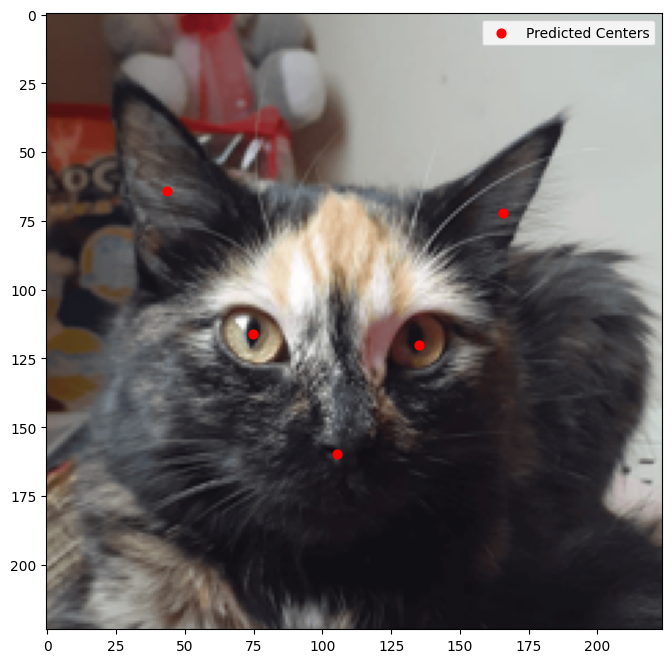

In [6]:
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, optim
from torchvision import models
from PIL import Image, ImageFile
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

# Permitir carga de imágenes truncadas
ImageFile.LOAD_TRUNCATED_IMAGES = True

class DenseNet121Regions(nn.Module):
    def __init__(self):
        super(DenseNet121Regions, self).__init__()
        self.backbone = models.densenet121(pretrained=True)
        self.backbone.classifier = nn.Identity()  # Eliminar la capa fully connected original
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # 10 coordenadas (5 puntos de referencia)
        
    def forward(self, x):
        x = self.backbone(x)
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = self.fc3(x)  # La salida es un vector con 10 coordenadas
        return x

# Cargar el modelo entrenado
model = DenseNet121Regions().cuda()
model.load_state_dict(torch.load('RegionDetector V2.pth'))
model.eval()

# Transformaciones para la imagen de prueba
test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2(),
])

# Función para redimensionar los puntos al tamaño original
def rescale_points(pred_points, orig_size, resized_size=(224, 224)):
    scale_x = orig_size[0] / resized_size[0]
    scale_y = orig_size[1] / resized_size[1]
    return pred_points * np.array([scale_x, scale_y])

# Función para predecir y graficar sobre la imagen original
def predict_and_visualize(model, image_path):
    try:
        # Cargar imagen original y obtener su tamaño
        image = Image.open(image_path).convert('RGB')
        orig_size = image.size
        image_np = np.array(image)
        
        # Transformar la imagen para la predicción
        augmented = test_transform(image=image_np)
        image_tensor = augmented['image'].unsqueeze(0).cuda()
        
        # Hacer la predicción
        with torch.no_grad():
            output = model(image_tensor)
        
        # Convertir la salida a coordenadas y redimensionarlas al tamaño original
        pred_points = output.cpu().numpy().reshape(-1, 2)
        pred_points = rescale_points(pred_points, orig_size)
        
        # Graficar los puntos sobre la imagen original
        plt.figure(figsize=(8, 8))
        plt.imshow(image_np)
        plt.scatter(pred_points[:, 0], pred_points[:, 1], c='red', s=40, label='Predicted Centers')
        plt.legend()
        plt.show()
        
    except OSError as e:
        print(f"Error al cargar la imagen {image_path}: {e}")
        # Opcionalmente, puedes decidir omitir la imagen o intentar cargar otra

# Ruta de la imagen a probar
muestra_path = os.path.join("..", "cropped_images")
# Path to the image to test
image_path = os.path.join(muestra_path, "cropped_muestra.png")
predict_and_visualize(model, image_path)
